# Abstract

This post attempts to replicate the study [Dissecting racial bias in an algorithm used to manage the health of populations by Obermeyer et al (2019)](https://www.science.org/doi/full/10.1126/science.aax2342). We looked at figures 1 and 3 in the paper that maps out racial disparities in the health care system. We will also looked at the disparities between black and white patients with 5 or fewer chronic illnesses. We are able to find the algorithm perpetuates racial disparities, as black patients are given less risk scores even with the same number of chronic illnesses. This decreases the likelihood of black patients getting appropriate care compared to the same conditions in white patients. With the complexity of the healthcare system, which has its own sets of disparities, this algorithm only reveals the systems that disproproitantely affect black people.

# Part A

We will use a randomized version of the data provided by the study so we can analyze the same types of patterns:

In [5]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

In [2]:
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


# Part B: Reproducing Figure 1

We will reproduce Figure 1A of Fig. 1A of Obermeyer et al. (2019) in order to visuzlize risk score penalties against mean number of chronic conditions in that percentile. We will attempt to show the disparities between races in calculating risk scores for how many illenesses they may have.

Text(0, 0.5, 'Risk Score Percentile')

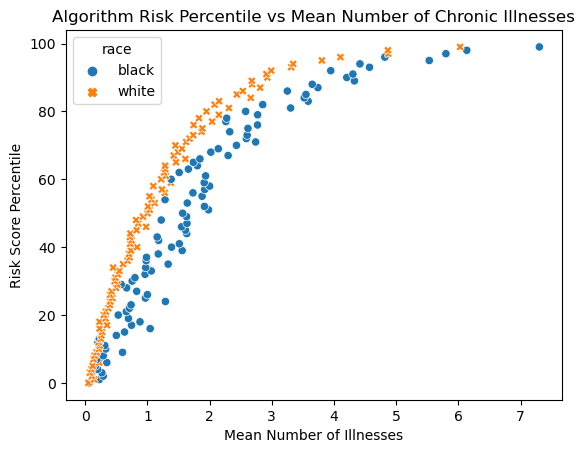

In [13]:
# Create a new percentile column based on the risk score
df['risk_percentile'] = pd.qcut(df['risk_score_t'], q=100, labels=False, duplicates='drop')

#getting a mean number of illnesses
mean_illness_percentiles = df.groupby(['risk_percentile', 'race'])['gagne_sum_t'].mean().reset_index()

percentile_plot = sns.scatterplot(data=mean_illness_percentiles, x='gagne_sum_t', y='risk_percentile', hue='race', style='race')
percentile_plot.set_title('Algorithm Risk Percentile vs Mean Number of Chronic Illnesses')
percentile_plot.set_xlabel('Mean Number of Illnesses')
percentile_plot.set_ylabel('Risk Score Percentile')

The first figure shows there is a clear disparity between black and white patients' scores. When we compare their actual mean number of illnesses against the scores, Black patients generally have a lower risk score for the same given number of illnesses. This means Black patients need to be more sick (more illnesses) to be referred to a care program.

# Part C: Reproducing Figure 3

Figure 3 in the sutdy looks at the mean medical expenditure to percentile of the risk score. It also calculated the  mean total expentiture to the number of chronic illnesses.

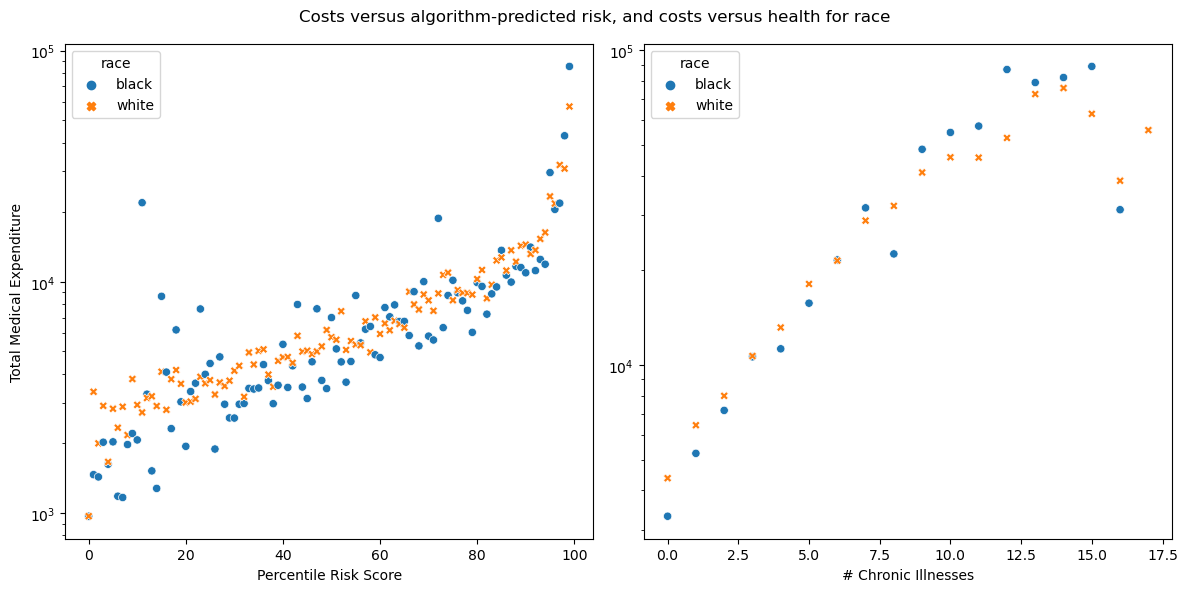

In [17]:
# again making risk percentile
df['risk_percentile'] = pd.qcut(df['risk_score_t'], q=100, labels=False, duplicates='drop')


cost_risk_percentiles = df.groupby(['risk_percentile', 'race'])['cost_t'].mean().reset_index()
cost_illness_percentiles = df.groupby(['gagne_sum_t', 'race'])['cost_t'].mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=cost_risk_percentiles, x='risk_percentile', y='cost_t', hue='race', style='race', ax=axs[0])
sns.scatterplot(data=cost_illness_percentiles, x='gagne_sum_t', y='cost_t', hue='race', style='race', ax=axs[1])


axs[1].set_ylabel('')
axs[1].set_xlabel('# Chronic Illnesses')
axs[1].set_yscale('log')
axs[0].set_ylabel('Total Medical Expenditure')
axs[0].set_xlabel('Percentile Risk Score')
axs[0].set_yscale('log')

fig.suptitle("Costs versus algorithm-predicted risk, and costs versus health for race")
plt.tight_layout()
plt.show()

In the left figure for figure 3, we can see that black patients average lower medical expenditure per risk score and the outliers are mostly black patients. The second figure shows as the number of chronic illnesses goes up, there is a general trend towards disparity. Black patients tend to get fewer costs than white patients at lower number of illnesses, but eventually this trend falls apart, possibly due to less data available at higher illness counts. 

# Part D: Modeling Cost Disparity

Given the disparity we just observed, we can explore patients that have 5 or fewer chronic illnesses.

We need to prep the data by determining the percentage of patients with 5 or fewer chronic illnesses:

In [19]:
percentage_chronic = len(df.loc[df['gagne_sum_t'] <= 5])/ len(df) * 100
percentage_chronic

95.53952115447689

With 95% of patients that have 5 or fewer active chronic illnesses, we will have a good idea of common racial disparity trends.

Now we want to make a new column to see the logarithm of the cost, but only look at costs above 0:

In [33]:
df_model = df.copy()
df_model = df_model[df_model['cost_t'] > 0]
df_model['log_cost'] = np.log(df_model['cost_t'])
df_model['log_cost'] = np.log(df_model['cost_t'])

We should also encode the race categories into numeric values. 0 correlates to white and 1 correlates to black.

In [34]:
df_model['race_binary'] = (df_model['race'] == 'black') * 1

We will also separate data into the predictions X and the targets y.  The predictor variables are based on race and # of chronic illnesses.

In [35]:
df_X = df_model[['race_binary','gagne_sum_t']]
df_y = df_model[['log_cost']]

# Modeling

We can implement a linear regression model, but because this relationship is nonlinear we need to add polynomial features. To find out how many features we need to add, we can use a loop provided by Prof Chodrow:

In [39]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

scores = []

for i in range(20):
  X_ = add_polynomial_features(df_X, i)
  LR = LinearRegression()
  LR.fit(X_, df_y)
  cv_score = cross_val_score(LR, X_, df_y, cv=5)
  scores.append((i, cv_score.mean()))


print(max(scores, key=lambda x: x[1]))

(10, 0.14830062340213399)


It seems that degree 10 is the highest so we will use that to make a new feature matrix and fit our model:

In [42]:
X_poly = add_polynomial_features(df_X, 10)
LR = LinearRegression()
LR.fit(X_poly, df_y)

print(X_poly)
print(LR.coef_)

       race_binary  gagne_sum_t  poly_1  poly_2  poly_3  poly_4  poly_5  \
0                0            0       0       0       0       0       0   
1                0            3       3       9      27      81     243   
2                0            0       0       0       0       0       0   
3                0            0       0       0       0       0       0   
4                0            1       1       1       1       1       1   
...            ...          ...     ...     ...     ...     ...     ...   
48779            0            0       0       0       0       0       0   
48780            0            1       1       1       1       1       1   
48781            0            0       0       0       0       0       0   
48782            0            3       3       9      27      81     243   
48783            0            0       0       0       0       0       0   

       poly_6  poly_7  poly_8  poly_9  
0           0       0       0       0  
1         729    21

Printing out our new coef_ of the linear regression, we see that the race coefficient was the first column and correlates with -2.67. Now we can calculate the wb value: 

In [44]:
wb = np.exp(LR.coef_[0][0])
wb

0.7655851197936364

Overall, we find that the cost incurred by black patients is 76.5% compared to white patients with 5 or less chronic illnesses. This supports the argument from the study that black patients have lower costs because they do not receive as much needed healthcare, revealing racial biases.

# Discussion

Through replicating these figures, I found a racial bias. Black patients with the same illnesses in real life are given lower risk scores, making their care less of a priority and unable to enroll in care programs. This disparity may be due to existing racial disparities that prevent healthcare access—therefore cheaper healthcare—to black patients.

In terms of the sufficiency outlined by Barocas, Hardt, and Narayanan (2023), the algorithm here gives differing outcomes dependent on race, even though they should be the same. Black patients are less qualified for healthcare even with less chronic conditions.

The algorithm may also fail the test of independence. Since health is tightly bound by healthcare costs and other systems that perpetuate racial disparities, the score is not as independent as it should be.